In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [4]:
# Set the max_columns to be displayed to be 35, which is the number of columns in the data frame.
pd.options.display.max_columns = 60
pd.options.display.max_rows = 100

In [5]:
# Load the extracted features.
path = "/data_alt/WorkData/VocalImplicitBias/PreprocInterFiles/"
df_1998 = pd.read_csv(path+'audio_feature_1998_422.csv')
df_1999 = pd.read_csv(path+'audio_feature_1999_422.csv')
df_2003 = pd.read_csv(path+'audio_feature_2003_422.csv')
df_2004 = pd.read_csv(path+'audio_feature_2004_422.csv')
df_2005 = pd.read_csv(path+'audio_feature_2005_422.csv')
df_2006 = pd.read_csv(path+'audio_feature_2006_422.csv')
df_2007 = pd.read_csv(path+'audio_feature_2007_422.csv')
df_2008 = pd.read_csv(path+'audio_feature_2008_422.csv')
df_2009 = pd.read_csv(path+'audio_feature_2009_422.csv')
df_2010 = pd.read_csv(path+'audio_feature_2010_422.csv')
df_2011 = pd.read_csv(path+'audio_feature_2011_422.csv')
df_2012 = pd.read_csv(path+'audio_feature_2012_422.csv')

In [6]:
frames = [df_1998, df_1999, df_2003, df_2004, df_2005, df_2006, df_2007, 
          df_2008, df_2009, df_2010, df_2011, df_2012]
# Concatenate them into a big frame.
df = pd.concat(frames)

In [7]:
# Discard samples with NaN values.
df = df.dropna()

In [8]:
# Create dummy variables for vowel, add them to the data frame as new columns.
dummies_vowel = pd.get_dummies(df['vowel'], prefix= 'vowel')

In [9]:
# Drop features that are unnormalized or unhelpful.
df = df.drop(['vowel', 'speaker_name', 'speaker_id'], axis=1)

df = pd.concat([df, dummies_vowel], axis=1)

In [10]:
'''
Separate the dataframe into two dataframes, separately the one consisting of
neutral samples and the one consisting of male & female words.
'''
neutral_samples = df.loc[df['classify']==0]
data_set = df.loc[df['classify'] != 0]

In [11]:
print('There are ', neutral_samples.shape[0], ' neutral words.')

('There are ', 8228774, ' neutral words.')


In [12]:
# Separate further and get a dataframe of male words only and a dataframe of female words only.
female_samples = data_set.loc[data_set['classify']==-1]
male_samples = data_set.loc[data_set['classify']==1]

In [13]:
print('There are ', female_samples.shape[0], ' female words.')
print('There are ', male_samples.shape[0], ' male words.')

('There are ', 5226, ' female words.')
('There are ', 34863, ' male words.')


In [14]:
# Shuffle the data so that we are not always getting the samples from the early years.
female_samples = shuffle(female_samples)
male_samples = shuffle(male_samples)
neutral_samples = shuffle(neutral_samples)

In [15]:
# Obtain the training set of 2980 male words and 2980 female words.
train_set = pd.concat([female_samples.iloc[range(2980)], male_samples.iloc[range(2980)]])

In [16]:
# Obtain the validation set of 990 male words and 990 female words for searching hyperparameters.
val_set = pd.concat([female_samples.iloc[range(2980, 3970)], 
                     male_samples.iloc[range(2980, 3970)]])

# Obtain the test set of 990 male words and 990 female words for checking performance.
test_set = pd.concat([female_samples.iloc[range(3970, 4960)], 
                     male_samples.iloc[range(3970, 4960)]])

In [17]:
# Shuffle the train_set, val_set and test_set.
train_set = shuffle(train_set)
val_set = shuffle(val_set)
test_set = shuffle(test_set)

In [18]:
# As we've finished shuffling, get train_set, test_set and val_set
# with features indicating identity dropped.
train_set_dropped = train_set.drop(['docket_id', 'text'], axis=1)
val_set_dropped = val_set.drop(['docket_id', 'text'], axis=1)
test_set_dropped = test_set.drop(['docket_id', 'text'], axis=1)

In [19]:
# Process and get X_train, y_train, x_val, y_val, x_test, y_test
y_train = train_set_dropped[['classify']]
x_train = train_set_dropped.drop(['classify'], axis=1)
y_val = val_set_dropped[['classify']]
x_val = val_set_dropped.drop(['classify'], axis=1)
y_test = test_set_dropped[['classify']]
x_test = test_set_dropped.drop(['classify'], axis=1)

In [20]:
# List of features involved in modeling.
predictors = list(x_train.columns)

In [21]:
# Convert data frames into numpy ndarrays.
y_train = y_train.values
x_train = x_train.values

y_val = y_val.values
x_val = x_val.values

y_test = y_test.values
x_test = x_test.values

# Adjust the shape of the labels.
y_train = y_train.reshape(y_train.shape[0],)
y_val = y_val.reshape(y_val.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)

In [22]:
model = RandomForestClassifier()

# Set the grid of parameters among which we will search for hyperparameters.
param_grid = {"max_depth": [30, 50, 70, 100, None],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators": [50, 70, 100],
              "criterion": ['gini', 'entropy'],
              "bootstrap": ['True', 'False']}

clf = GridSearchCV(model, param_grid=param_grid)

In [23]:
clf.fit(x_val, y_val)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': ['True', 'False'], 'min_samples_leaf': [1, 3, 10], 'n_estimators': [50, 70, 100], 'criterion': ['gini', 'entropy'], 'min_samples_split': [3, 10], 'max_depth': [30, 50, 70, 100, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
clf.best_params_

{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [25]:
model = RandomForestClassifier(criterion = 'gini', max_depth = 50, min_samples_leaf = 3,
 min_samples_split = 10, n_estimators = 100)

In [26]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# The accuracy of prediction on the training set.
model.score(x_train, y_train)

0.98104026845637582

In [28]:
# Without a consideration of margin, the accuracy of the prediction on the test set.
model.score(x_test, y_test)

0.8292929292929293

In [29]:
y_test_pred = model.predict(x_test)

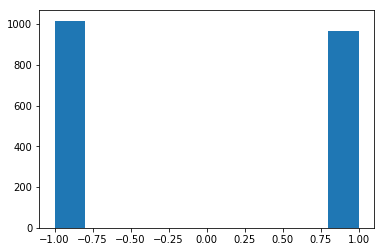

In [30]:
# Have a general idea of the distribution of prediction.
plt.hist(y_test_pred)

plt.show()

In [31]:
# Ranking of features with respect to their importance.
features = pd.DataFrame()
features['feature'] = predictors
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'],ascending=False)

,feature,importance
8,f1@20%_n,0.086516
27,vowel_IH,0.059772
13,f2@20%_n,0.056032
14,f2@35%_n,0.054893
4,f3_n,0.053233
3,f2_n,0.052993
6,B2_n,0.048681
17,f2@80%_n,0.048577
5,B1_n,0.046339
16,f2@60%_n,0.045687


In [32]:
# Test on neutral words.
neutral_samples_dropped = neutral_samples.drop(['docket_id', 'text'], axis=1)

y_neutral = neutral_samples_dropped[['classify']]
x_neutral = neutral_samples_dropped.drop(['classify'], axis=1)
y_neutral = y_neutral.values
x_neutral = x_neutral.values

y_neutral = y_neutral.reshape(y_neutral.shape[0],)

In [33]:
neutral_predict_proba = model.predict_proba(x_neutral)

In [40]:
print neutral_predict_proba

[[ 0.56182662  0.43817338]
 [ 0.59686519  0.40313481]
 [ 0.67838408  0.32161592]
 ..., 
 [ 0.6609589   0.3390411 ]
 [ 0.23097818  0.76902182]
 [ 0.49395647  0.50604353]]


In [34]:
model.classes_

array([-1.,  1.])

In [41]:
numOfMale = neutral_predict_proba[neutral_predict_proba[:,1]>0.75].shape[0]
print numOfMale

1013156


In [42]:
numOfFemale = neutral_predict_proba[neutral_predict_proba[:,0]>0.75].shape[0]
print numOfFemale

583976


In [43]:
totalNeutralWords = neutral_predict_proba.shape[0]
print totalNeutralWords

8228774


In [45]:
print (numOfMale+numOfFemale)*1.0/totalNeutralWords

0.194091124632


In [46]:
(numOfFemale)*1.0/(numOfFemale+numOfMale)

0.365640410435706

In [47]:
result = pd.DataFrame()
result['docket_id'] = neutral_samples['docket_id']
result['text'] = neutral_samples['text']
result['probability_of_male'] = neutral_predict_proba[:,1]
result['probability_of_female'] = neutral_predict_proba[:, 0]

In [48]:
result.sort_values(by=['probability_of_male'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
212623,2009_08_351,EXCEEDS,1.000000,0.000000
212509,2009_08_351,EXCEEDS,1.000000,0.000000
212373,2009_08_351,EXCEEDS,1.000000,0.000000
943339,2004_04_278,REALLY,0.997556,0.002444
943543,2004_04_278,REALLY,0.997556,0.002444
113131,1999_98_1170,DIFFICULT,0.997273,0.002727
353897,2010_09_658,HILL,0.997009,0.002991
353272,2010_09_658,HILL,0.997009,0.002991
468281,2006_05_9222,THIS,0.996667,0.003333
467895,2006_05_9222,THIS,0.996667,0.003333


In [49]:
result.sort_values(by=['probability_of_female'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
71342,1998_97_1147,PULL,0.005000,0.995000
71119,1998_97_1147,PULL,0.005000,0.995000
201128,2007_06_1286,FULL,0.005333,0.994667
200928,2007_06_1286,FULL,0.005333,0.994667
348779,1999_98_1949,LOOKING,0.006111,0.993889
348488,1999_98_1949,LOOKING,0.006111,0.993889
151189,2006_05_1342,FULFILL,0.006667,0.993333
589514,2008_08_146,WOULDN'T,0.009167,0.990833
589547,2008_08_146,WOULDN'T,0.009167,0.990833
660192,2008_08_267,HANDFUL,0.013810,0.986190


In [50]:
# Get a list of vowel dummy variables
vowel_predictors = []
for e in list(df.columns.values):
    if e[:5] == 'vowel':
        vowel_predictors.append(e)

In [51]:
# Set up for testing without vowel.
x_train_without_vowel = train_set_dropped.drop(['classify'], axis=1)
x_train_without_vowel = x_train_without_vowel.drop(vowel_predictors, axis=1)
predictors_without_vowel = list(x_train_without_vowel.columns)
x_train_without_vowel = x_train_without_vowel.values
y_train_without_vowel = y_train
x_val_without_vowel = val_set_dropped.drop(['classify'], axis=1)
x_val_without_vowel = x_val_without_vowel.drop(vowel_predictors, axis=1).values
y_val_without_vowel = y_val
x_test_without_vowel = test_set_dropped.drop(['classify'], axis=1)
x_test_without_vowel = x_test_without_vowel.drop(vowel_predictors, axis=1).values
y_test_without_vowel = y_test
x_neutral_without_vowel = neutral_samples_dropped.drop(['classify'], axis=1)
x_neutral_without_vowel = x_neutral_without_vowel.drop(vowel_predictors, axis=1).values
y_neutral_without_vowel = y_neutral

In [52]:
model2 = RandomForestClassifier()

# Set the grid of parameters among which we will search for hyperparameters.
param_grid = {"max_depth": [30, 50, 70, 100, None],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators": [50, 70, 100],
              "criterion": ['gini', 'entropy'],
              "bootstrap": ['True', 'False']}

clf2 = GridSearchCV(model2, param_grid=param_grid)

In [53]:
clf2.fit(x_val_without_vowel, y_val_without_vowel)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bootstrap': ['True', 'False'], 'min_samples_leaf': [1, 3, 10], 'n_estimators': [50, 70, 100], 'criterion': ['gini', 'entropy'], 'min_samples_split': [3, 10], 'max_depth': [30, 50, 70, 100, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
clf2.best_params_

{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50}

In [55]:
model_without_vowel = RandomForestClassifier(criterion = 'entropy', max_depth=70, min_samples_split=3, 
                              min_samples_leaf=3, n_estimators=100)
model_without_vowel.fit(x_train_without_vowel, y_train_without_vowel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
model_without_vowel.score(x_train_without_vowel, y_train_without_vowel)

0.99681208053691273

In [57]:
model_without_vowel.score(x_test_without_vowel, y_test_without_vowel)

0.8196969696969697

In [58]:
y_test_pred_without_vowel = model_without_vowel.predict(x_test_without_vowel)

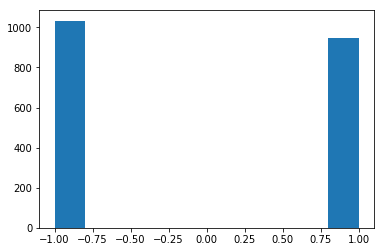

In [59]:
# Have a general idea of the distribution of prediction.
plt.hist(y_test_pred_without_vowel)

plt.show()

In [60]:
# Ranking of features with respect to their importance.
features_without_vowel = pd.DataFrame()
features_without_vowel['feature'] = predictors_without_vowel
features_without_vowel['importance'] = model_without_vowel.feature_importances_
features_without_vowel.sort_values(by=['importance'],ascending=False)

,feature,importance
8,f1@20%_n,0.089066
13,f2@20%_n,0.063841
4,f3_n,0.060145
6,B2_n,0.059326
5,B1_n,0.056901
17,f2@80%_n,0.056235
14,f2@35%_n,0.056112
3,f2_n,0.054534
1,t_n,0.053266
16,f2@60%_n,0.053174


In [61]:
# Test on neutral words.
neutral_predict_without_vowel = model_without_vowel.predict_proba(x_neutral_without_vowel)

In [62]:
model_without_vowel.classes_

array([-1.,  1.])

In [63]:
numOfFemale_without_vowel = neutral_predict_without_vowel[abs(neutral_predict_without_vowel[:,0])>0.75].shape[0]
numOfMale_without_vowel = neutral_predict_without_vowel[abs(neutral_predict_without_vowel[:,1])>0.75].shape[0]

In [65]:
(numOfFemale_without_vowel+numOfMale_without_vowel)*1.0/totalNeutralWords

0.0668467745012805

In [66]:
numOfFemale_without_vowel*1.0/(numOfMale_without_vowel+numOfFemale_without_vowel)

0.4040962282776462

In [67]:
result2 = pd.DataFrame()
result2['docket_id'] = neutral_samples['docket_id']
result2['text'] = neutral_samples['text']
result2['probability_of_male'] = neutral_predict_without_vowel[:,1]
result2['probability_of_female'] = neutral_predict_without_vowel[:, 0]

In [68]:
result2.sort_values(by=['probability_of_male'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
727539,1999_99_478,INCREASE,0.982667,0.017333
727665,1999_99_478,INCREASE,0.982667,0.017333
151320,2004_03_1160,THESE,0.978024,0.021976
272051,1999_98_1682,INDEED,0.976250,0.023750
272019,1999_98_1682,INDEED,0.976250,0.023750
272192,1999_98_1682,INDEED,0.976250,0.023750
640943,2007_07_411,HERE,0.975738,0.024262
641244,2007_07_411,HERE,0.975738,0.024262
641064,2007_07_411,HERE,0.975738,0.024262
740345,2007_07_6053,HEARSAY,0.974119,0.025881


In [69]:
result2.sort_values(by=['probability_of_female'],ascending=False).head(n=100)

,docket_id,text,probability_of_male,probability_of_female
153733,1999_98_1255,IN,0.019333,0.980667
153528,1999_98_1255,IN,0.019333,0.980667
153908,1999_98_1255,IN,0.019333,0.980667
526135,1999_98_9828,AFTER,0.020000,0.980000
525928,1999_98_9828,AFTER,0.020000,0.980000
525986,1999_98_9828,AFTER,0.020000,0.980000
410251,2010_09_804,P,0.021167,0.978833
91462,2010_09_1227,STATUTE,0.022500,0.977500
91662,2010_09_1227,STATUTE,0.022500,0.977500
91896,2010_09_1227,STATUTE,0.022500,0.977500
